In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../modeldata/IntCompair.csv')

In [3]:
dataset = dataset.drop('logInstT3BR', axis=1)

In [4]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [5]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.97 s, sys: 43.5 ms, total: 6.02 s
Wall time: 6.01 s


In [6]:
dataset['log']= np.log10(dataset['ThetaSTD']/1.8)

In [7]:
dataset.describe()


,index,MEGNO,MEGNOstd,threeBRfillfac,threeBRfillstd,chiSec,ThetaSTD,p2/1,p3/2,Zval12,...,Zcrit23,IntZval12,IntZval23,EMcrossnear,EMcrossfar,EMcrossouter,instability_time,shadow_instability_time,hasnull,log
count,138543.000000,131150.000000,131150.000000,131150.000000,1.311500e+05,138543.000000,131150.000000,138543.000000,138543.000000,138543.000000,...,1.385430e+05,138543.000000,138543.000000,138543.000000,138543.000000,138543.000000,1.385430e+05,1.385430e+05,138543.000000,131150.000000
mean,69271.000000,6.232303,1.215945,1.359796,8.319864e+09,0.501295,13.368637,1.418755,1.422836,0.041550,...,6.179803e+41,0.044549,0.040546,0.150181,0.362667,0.578510,2.863147e+08,2.925407e+08,0.053362,0.021203
std,39994.063509,11.516257,3.124624,14.562645,3.010634e+12,0.381965,24.212453,0.340741,0.345986,0.050787,...,2.300197e+44,0.050888,0.041872,0.112919,0.203083,0.349974,4.371732e+08,4.417942e+08,0.224756,0.942435
min,0.000000,-0.430259,0.000004,0.004187,2.528506e-07,0.000003,0.003778,1.007289,1.006925,0.000010,...,1.055361e+00,0.000014,0.000008,0.004612,0.006545,0.012454,3.464102e-02,0.000000e+00,0.000000,-2.677987
25%,34635.500000,1.978115,0.006879,0.159031,5.782035e-04,0.091313,0.347063,1.166666,1.166752,0.010355,...,1.746584e+00,0.012827,0.012434,0.072493,0.201376,0.315946,6.485543e+04,5.858617e+04,0.000000,-0.714864
50%,69271.000000,2.005367,0.041101,0.444107,4.237097e-03,0.502829,1.063887,1.307033,1.310603,0.024657,...,3.089374e+00,0.028193,0.026990,0.118127,0.320830,0.500692,1.484704e+06,1.498063e+06,0.000000,-0.228377
75%,103906.500000,3.345559,0.466819,1.217691,2.582538e-02,0.910490,16.073656,1.586583,1.590345,0.052984,...,1.809699e+01,0.056928,0.053661,0.186970,0.491676,0.761991,1.000000e+09,1.000000e+09,0.000000,0.950842
max,138542.000000,130.498145,38.305852,2302.130815,1.090290e+15,0.999997,438.212098,3.251143,3.117589,0.703917,...,8.561648e+46,0.703917,0.465820,0.982453,1.194679,3.124353,1.000050e+09,1.000050e+09,1.000000,2.386412


In [51]:
IntDat = ['threeBRfillfac','log','Zcrit12','Zcrit23','IntZval12','IntZval23','MEGNO','EMcrossnear','EMcrossfar']
Dat = ['threeBRfillfac','log','Zcrit12','Zcrit23','Zval12','Zval23','MEGNO','EMcrossnear','EMcrossfar']


In [9]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [31]:
filtData.columns

Index(['index', 'MEGNO', 'MEGNOstd', 'threeBRfillfac', 'threeBRfillstd',
       'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12', 'Zcrit12', 'Zval23',
       'Zcrit23', 'IntZval12', 'IntZval23', 'EMcrossnear', 'EMcrossfar',
       'EMcrossouter', 'prelimStable', 'Stable', 'instability_time',
       'shadow_instability_time', 'hasnull', 'log', 'dup'],
      dtype='object')

In [11]:
plot = filtData
plot['dup']=plot[['threeBRfillfac','EMcrossnear','instability_time','MEGNO']].duplicated()
plot = plot.drop(plot[plot['dup']==True].index)

/tmp/ipykernel_130717/3080585920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot['dup']=plot[['threeBRfillfac','EMcrossnear','instability_time','MEGNO']].duplicated()


In [12]:
scrambled = plot.sample(frac=1)

In [13]:
scrambled = scrambled.reset_index()

In [46]:
scrambled[Dat]

,threeBRfillfac,log,Zcrit12,Zcrit23,Zval12,Zval23,MEGNO,EMcrossnear,EMcrossfar,ThetaSTD
0,3.503745,-1.038844,2.510356,739.112055,0.041002,0.019896,2.644201,0.073485,0.157783,0.164600
1,0.053175,1.543035,1.693512,2.282515,0.036179,0.097654,9.789362,0.333274,0.476282,62.850313
2,1.144211,1.387709,118.968669,1.929880,0.001219,0.011890,2.134623,0.042566,0.444951,43.952279
3,1.826940,-0.145387,2.601246,51.413867,0.012783,0.001170,1.976008,0.057105,0.197075,1.287909
4,0.179193,-0.226433,4.505629,1.739087,0.031753,0.103510,2.371802,0.100081,0.351467,1.068660
...,...,...,...,...,...,...,...,...,...,...
120276,0.038561,-0.670735,1.928896,1.470022,0.105602,0.060003,2.038789,0.411026,0.588321,0.384183
120277,0.204447,-0.277578,1.724118,2.074942,0.109054,0.085454,0.902006,0.390986,0.408096,0.949935
120278,0.636134,-0.374211,1.432844,6.010711,0.247456,0.023767,1.964939,0.250514,0.668410,0.760434
120279,0.179244,-1.215366,26.349147,1.445262,0.038084,0.030306,1.875697,0.161656,0.756068,0.109624


In [15]:
scrambled = scrambled.drop(scrambled[scrambled['Zcrit12']>1e5].index)
scrambled = scrambled.drop(scrambled[scrambled['Zcrit23']>1e5].index)


In [16]:
scrambled

,level_0,index,MEGNO,MEGNOstd,threeBRfillfac,threeBRfillstd,chiSec,ThetaSTD,p2/1,p3/2,...,EMcrossnear,EMcrossfar,EMcrossouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,log,dup
0,116300,116300,2.644201,0.160049,3.503745,0.076430,0.001835,0.164600,1.245776,1.112218,...,0.073485,0.157783,0.242862,True,False,1.849337e+06,7.041105e+05,0,-1.038844,False
1,3065,3065,9.789362,2.733337,0.053175,0.000392,0.909528,62.850313,1.793682,1.539498,...,0.333274,0.476282,0.968288,True,False,2.559192e+07,2.208848e+07,0,1.543035,False
2,76539,76539,2.134623,0.053464,1.144211,0.008040,0.747264,43.952279,1.064523,1.736861,...,0.042566,0.444951,0.506457,True,False,2.340223e+05,7.377923e+04,0,1.387709,False
3,113264,113264,1.976008,0.007085,1.826940,0.019557,0.322503,1.287909,1.309731,1.086869,...,0.057105,0.197075,0.265435,True,False,9.816609e+04,1.528434e+05,0,-0.145387,False
4,100128,100128,2.371802,0.140495,0.179193,0.002219,0.379830,1.068660,1.153817,1.571105,...,0.100081,0.351467,0.486723,True,False,1.414202e+04,1.383060e+04,0,-0.226433,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120276,53562,53562,2.038789,0.019613,0.038561,0.000168,0.904868,0.384183,1.676077,2.001737,...,0.411026,0.588321,1.241163,True,False,1.157342e+05,2.456490e+05,0,-0.670735,False
120277,101304,101304,0.902006,0.257798,0.204447,0.001157,0.073760,0.949935,1.640514,1.670853,...,0.390986,0.408096,0.958641,True,False,2.162817e+05,6.155709e+05,0,-0.277578,False
120278,62499,62499,1.964939,0.305771,0.636134,0.005305,0.001975,0.760434,2.154976,1.398361,...,0.250514,0.668410,1.086370,True,False,9.254447e+08,7.221762e+08,0,-0.374211,False
120279,112691,112691,1.875697,0.072112,0.179244,0.001284,0.983268,0.109624,1.251978,2.327078,...,0.161656,0.756068,1.039947,True,True,1.000000e+09,1.000000e+09,0,-1.215366,False


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [17]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [18]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [19]:
realTest = test.loc[test['prelimStable']==True]

In [20]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [21]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [22]:
from sklearn.metrics import accuracy_score

In [71]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [72]:
testModel.fit(train[Dat], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [73]:
resPred = testModel.predict_proba(tT[Dat])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[Dat]), tT["Stable"]))

0.9433848157721761
0.8572442173974741


0.9431740032502489
0.8571023130410104

In [58]:
tT.value_counts('Stable')

Stable
False    7300
True     6890
Name: count, dtype: int64

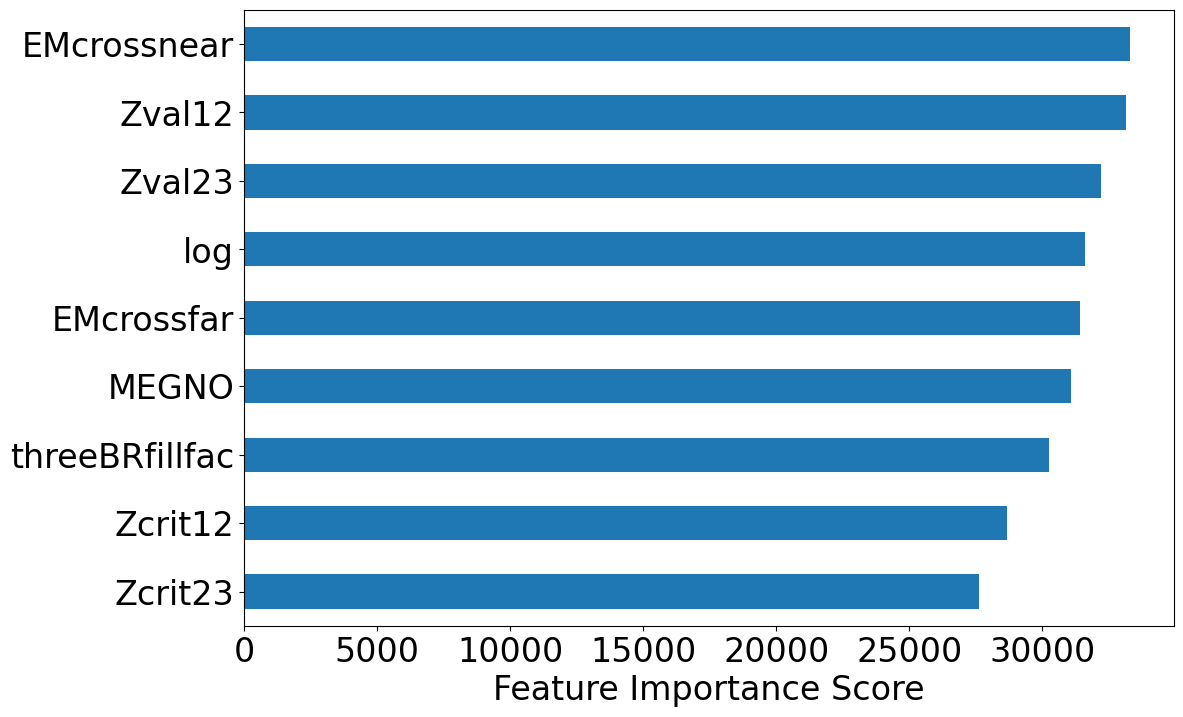

In [44]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')